## Scrapper

In [179]:
import praw
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from stop_words import get_stop_words #nltk не хотел устанавливать stop-words
from wordcloud import WordCloud

### Сбор данных

In [67]:
#ввожу данные для авторизации и получения доступа
reddit = praw.Reddit(
    client_id='S-OA2QSB5sLdEXJQo1QuDQ',
    client_secret='ry627ce5h-Ud-kqp_Jz5YQuAnRiPcg',
    user_agent='Shurik_project_v1, trend-analysis'
)

subreddit_name = 'AskReddit' #выбор сабреддита
subreddit = reddit.subreddit(subreddit_name)

posts = []

# Получаем посты за последний месяц (500 штук)
for post in subreddit.top(time_filter='month', limit=500):
    posts.append({
        'id': post.id,
        'title': post.title,
        'score': post.score,
        'num_comments': post.num_comments,
        'created_utc': post.created_utc,
        'url': post.url,
        'selftext': post.selftext
    })

In [80]:
#создаю датафрейм
df = pd.DataFrame(posts)
df.to_csv("~/Documents/PyWorkITMO/projects/reddit_analysis/notebooks/data/reddit_posts.csv", index=False)

#преобразую время
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

#удаление строк с пустыми заголовками
df = df[df['title'].notna()]

#удаление аномалий
df = df[(df['score'] >= 0) & (df['num_comments'] >= 0)]

#редакция заголовков
df['title'] = df['title'].str.strip().str.lower().str.findall(r'\b[a-zA-Z]+\b').str.join(' ')

print("\n Вывод:\n")
print(df.head())


 Вывод:

        id                                              title  score  \
0  1kgat3q  americans how do you feel about the firing of ...  26392   
1  1kjwuwx  george carlin once said never underestimate th...  25161   
2  1kaedko  how do you feel about mark carney and the libe...  24437   
3  1k7vp2r  people who escaped authoritarian governments w...  22114   
4  1k6oumh  donald trump is coming to the end of his first...  21630   

   num_comments         created_utc  \
0          6371 2025-05-06 17:46:16   
1          8490 2025-05-11 09:13:14   
2          7423 2025-04-29 03:23:28   
3          4716 2025-04-25 20:58:09   
4         16966 2025-04-24 10:28:18   

                                                 url selftext  
0  https://www.reddit.com/r/AskReddit/comments/1k...           
1  https://www.reddit.com/r/AskReddit/comments/1k...           
2  https://www.reddit.com/r/AskReddit/comments/1k...           
3  https://www.reddit.com/r/AskReddit/comments/1k...           
4 

### EDA

In [69]:
#проверка типов данных
print("\nТипы данных:\n")
df.info()

#статистика
print("\nОписательные статистики:\n")
print(df.describe())

#повторяющиеся заголовки
print("\nЧастые заголовки:\n")
df['title'].value_counts().head(5) #оказывается эти заголовки уникальны

#пропуски
print("\nКоличество пропущенных значений:")
df.isna().sum()



Типы данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            500 non-null    object        
 1   title         500 non-null    object        
 2   score         500 non-null    int64         
 3   num_comments  500 non-null    int64         
 4   created_utc   500 non-null    datetime64[ns]
 5   url           500 non-null    object        
 6   selftext      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 27.5+ KB

Описательные статистики:

              score  num_comments                    created_utc
count    500.000000    500.000000                            500
mean    2968.800000   2387.982000  2025-04-29 16:40:36.924000256
min      258.000000     60.000000            2025-04-14 03:19:36
25%      570.000000    791.500000  2025-04-22 05:31:29.750000128
50%     1

id              0
title           0
score           0
num_comments    0
created_utc     0
url             0
selftext        0
dtype: int64

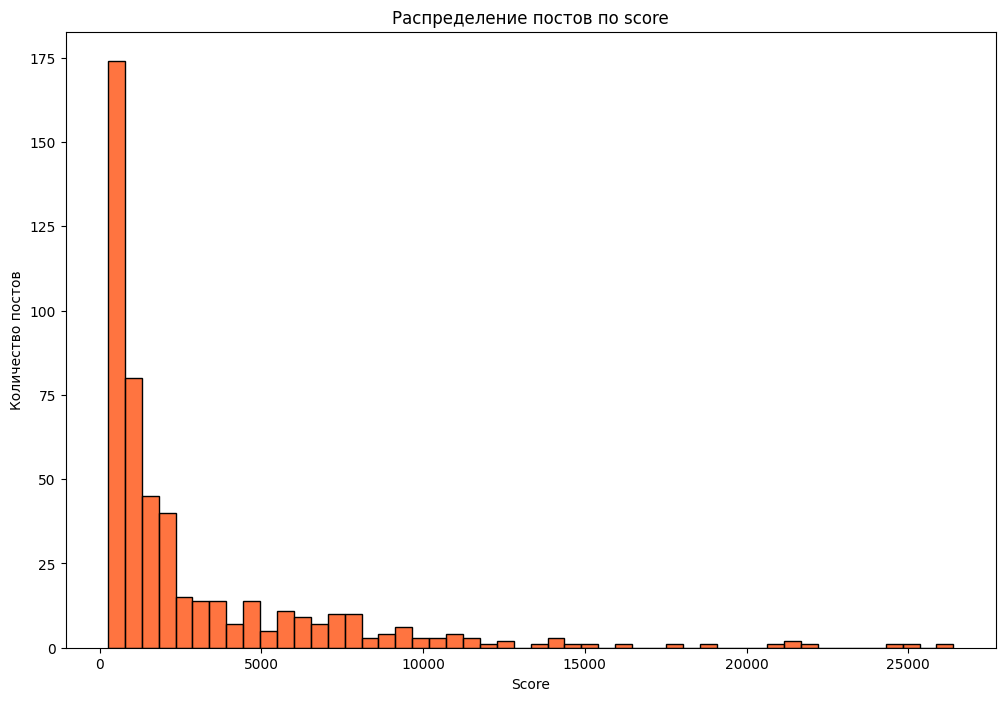

In [296]:
#визуализация
%matplotlib inline
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

sns.histplot(data=df, x='score', bins=50, ax=axs, color='#FF4500', edgecolor='black')  # гистограмма
axs.set_xlabel("Score")
axs.set_ylabel("Количество постов")
axs.set_title("Распределение постов по score")
plt.show()


### Визуализация

#### Облако слов

In [118]:
#обработка для узконаправленного анализа (облакло слов)
title_words = ' '.join(df['title'].astype(str).str.split().sum()) 
title_words = title_words.split()

#уберу стоп слова
stop_words = set(get_stop_words('english'))
title_words_filtered = [word for word in title_words if word not in stop_words and len(word) > 2]
title_words_ready = ' '.join(title_words_filtered)

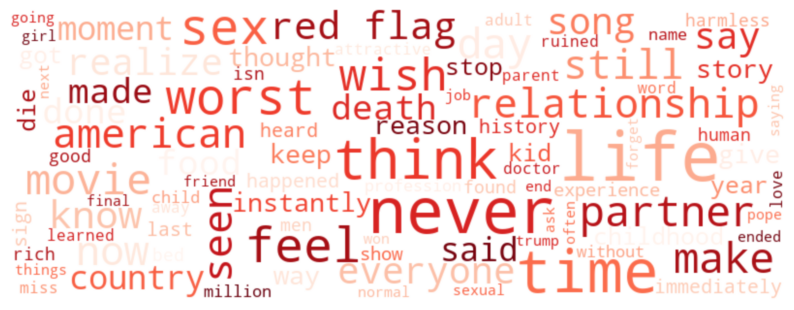

In [305]:
wordcloud = WordCloud(width=800, height=300, background_color='white', colormap = 'Reds', min_font_size=15, max_font_size=70).generate(title_words_ready)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')
plt.show()


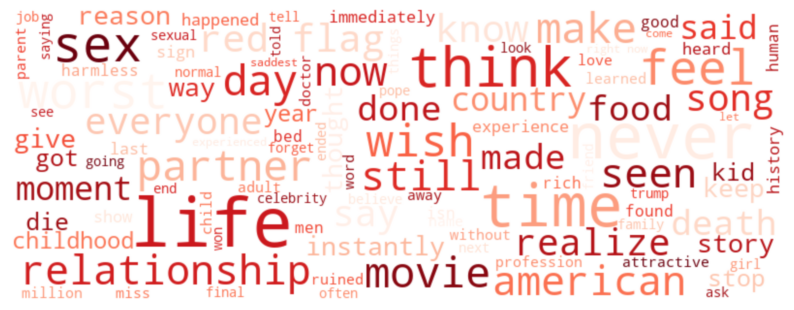

In [306]:
#добавлю свои stop-words
extra_stopwords = {'people', 'something', 'someone', 'thing', 'like', 'just', 'actually', 'one', 'non', 'person', 'first', 'reddit', 'biggest','best', 'completely', 'whats', 'don','will', 'every', 'back', 'even', 'really', 'somehow'}
stop_words = set(get_stop_words('english')).union(extra_stopwords)

title_words_filtered = [word for word in title_words if word not in stop_words and len(word) > 2]
title_words_ready = ' '.join(title_words_filtered)

wordcloud = WordCloud(width=800, height=300, background_color='white',colormap = 'Reds', min_font_size=12, max_font_size=70).generate(title_words_ready)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')
plt.show()

In [236]:
#из чистого интереса
word_counts = {}
word_needed = {'love'}

for word in title_words_filtered:
    if word in word_needed:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
print(word_counts)


{'love': 6}


In [206]:
word_counts = {}
word_needed = {'sex'}

for word in title_words_filtered:
    if word in word_needed:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
print(word_counts)

{'sex': 18}


#### Активность пользователей по дням недели

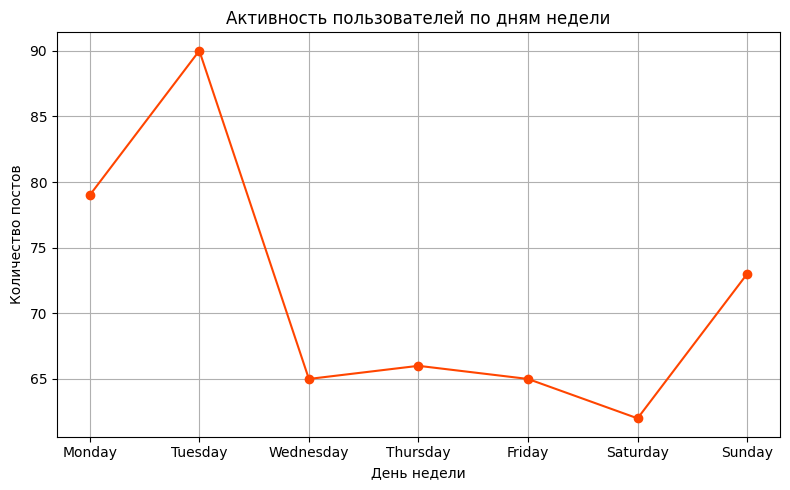

In [295]:
#выделяем дни недели
df['weekday'] = df['created_utc'].dt.day_name()


#порядок
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['weekday'].value_counts().reindex(days)

#создам график
plt.figure(figsize=(8, 5))
plt.plot(weekday_counts.index, weekday_counts.values, marker='o', color='#FF4500')
plt.title('Активность пользователей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество постов')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Анализ количества комментариев

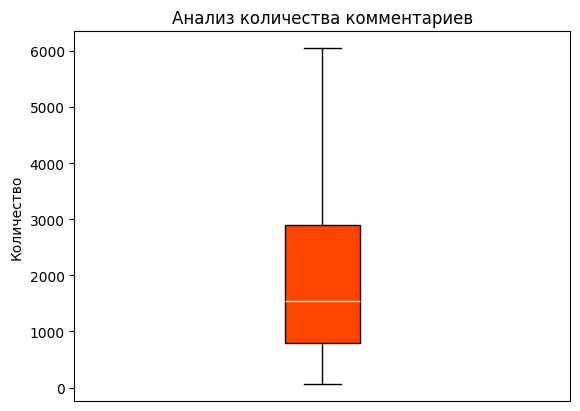

In [294]:
plt.boxplot(df['num_comments'], patch_artist=True, boxprops=dict(facecolor='#FF4500', color='black'),  medianprops=dict(color='white'), showfliers=False)
plt.title('Анализ количества комментариев')
plt.ylabel('Количество')
plt.xticks([])
plt.show()

In [318]:
#самые обсуждаемые темы
top_by_comments = df.sort_values(by='num_comments', ascending=False).head(5)
print(top_by_comments[['title', 'num_comments']])

                                                title  num_comments
13       how did that one kid in your high school die         24620
55  what s the first game you spent hundreds of ho...         16977
4   donald trump is coming to the end of his first...         16966
31  what is your best i say it wrong on purpose ex...         15904
22  if you won the lottery and never had to work a...         13389
